# HandSeg+MobileNetV3 Large Training Script

This script trains a Hand Gesture Classifier using a Hand Segmentation model as the first stage and a MobileNetV3 Large model as the second stage, using the [Hagrid Dataset for Classification](https://huggingface.co/datasets/cj-mills/hagrid-classification-512p-no-gesture-150k-zip). The Hand Segmentation model is used to obtain a mask of the hand in the image, which is used as an input to the MobileNetV3 model. The MobileNetV3 Large model is then trained to classify the hand gesture.

Two approaches are used for training:
1. **Frozen Hand Segmentation Training**: The Hand Segmentation model is pretrained and frozen. The MobileNetV3 Large model is trained using the output of the Hand Segmentation model.
2. **End-to-End Training**: The Hand Segmentation model is pretrained and fine-tuned along with the MobileNetV3 Large model.

The pretrained Hand Segmentation model is a DeepLabV3 model pretrained on the COCO dataset, and the implementation is taken from the [hands-segmentation-pytorch](https://github.com/guglielmocamporese/hands-segmentation-pytorch) repository.

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import models, transforms
from torchvision.utils import make_grid
import pytorch_lightning as pl
import numpy as np
from tqdm import tqdm
from typing import List
import os
import cv2
from sklearn.preprocessing import LabelEncoder
import pickle


c:\Users\berna\anaconda3\envs\cv-gesture\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Example Running the Pre-trained Hand Segmentation Model:

Lightning automatically upgraded your loaded checkpoint from v1.2.2 to v2.3.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint d:\Documents\GitHub\cv-gesture-recognition\handsegmentation\checkpoint\checkpoint.ckpt`


Using cpu


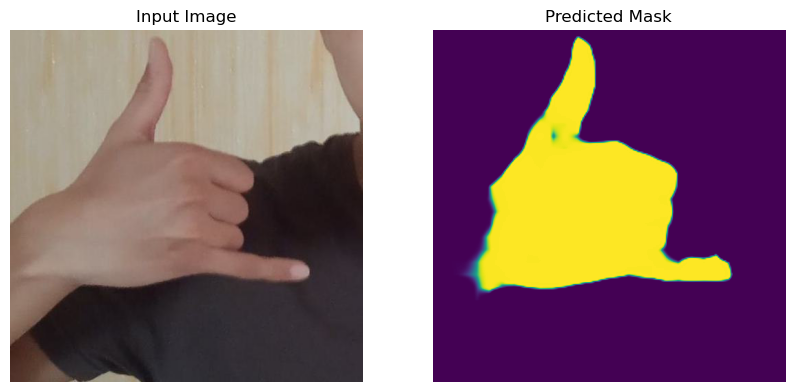

In [4]:

# Use CPU for the testing if available
torch.cuda.empty_cache()
device = torch.device("cpu")
print("Using", device)


# The following code was taken from the following repository:
# https://github.com/guglielmocamporese/hands-segmentation-pytorch
def meanIoU(logits, labels):
    """
    Computes the mean intersection over union (mIoU).
    
    Args:
        logits: tensor of shape [bs, c, h, w].
        labels: tensor of shape [bs, h, w].
    
    Output:
        miou: scalar.
    """
    num_classes = logits.shape[1]
    preds = F.softmax(logits, 1)
    preds_oh = F.one_hot(preds.argmax(1), num_classes).permute(0, 3, 1, 2).to(torch.float32) # [bs, c, h, w] 
    labels_oh = F.one_hot(labels, num_classes).permute(0, 3, 1, 2).to(torch.float32) # [bs, c, h, w]
    tps = (preds_oh * labels_oh).sum(-1).sum(-1) # true positives [bs, c]
    fps = (preds_oh * (1 - labels_oh)).sum(-1).sum(-1) # false positives [bs, c]
    fns = ((1 - preds_oh) * labels_oh).sum(-1).sum(-1) # false negatives [bs, c]
    iou = tps / (tps + fps + fns + 1e-8) # [bs, c]
    return iou.mean(-1).mean(0)

class Denorm(object):
    def __init__(self, mean=None, std=None):
        self.mean = np.array([0.0, 0.0, 0.0]) if mean is None else mean
        self.std = np.array([1.0, 1.0, 1.0]) if std is None else std

    def __call__(self, x):
        """
        Denormalize the image.

        Args:
            x: tensor of shape [bs, c, h, w].

        Output:
            x_denorm: tensor of shape [bs, c, h, w].
        """
        denorm_fn = transforms.Normalize(mean=- self.mean / (self.std + 1e-8), std=1.0 / (self.std + 1e-8))
        x_denorm = []
        for x_i in x:
            x_denorm += [denorm_fn(x_i)]
        x_denorm = torch.stack(x_denorm, 0)
        return x_denorm
    
class HandSegModel(pl.LightningModule):
    """
    This model is based on the PyTorch DeepLab model for semantic segmentation.
    """
    def __init__(self, pretrained=False, lr=1e-4, in_channels=3):
        super().__init__()
        assert in_channels in [1, 3, 4]
        self.deeplab = self._get_deeplab(pretrained=pretrained, num_classes=2, in_channels=in_channels)
        self.denorm_image_for_tb_log = None # For tensorboard logging
        self.lr = lr
        if pretrained:
            if in_channels == 1:
                mean, std = np.array([0.5]), np.array([0.5]) 
            elif in_channels == 3:
                mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225]) 
            elif in_channels == 4:
                mean, std = np.array([0.485, 0.456, 0.406, 0.5]), np.array([0.229, 0.224, 0.225, 0.5]) 
            self.denorm_image_for_tb_log = Denorm(mean, std)

    def _get_deeplab(self, pretrained=False, num_classes=2, in_channels=3):
        """
        Get the PyTorch DeepLab model architecture.
        """
        deeplab = models.segmentation.deeplabv3_resnet50(
            pretrained=False,
            num_classes=num_classes
        )
        if pretrained:
            deeplab_21 = models.segmentation.deeplabv3_resnet50(
                pretrained=True,
                progress=True,
                num_classes=21
            )
            for c1, c2 in zip(deeplab.children(), deeplab_21.children()):
                for p1, p2 in zip(c1.parameters(), c2.parameters()):
                    if p1.shape == p2.shape:
                        p1.data = p2.data
        if in_channels == 1:
            weight = deeplab.backbone.conv1.weight
            deeplab.backbone.conv1.weight = nn.Parameter(weight.data[:, 0:1])
        elif in_channels == 4:
            weight = deeplab.backbone.conv1.weight
            C, _, H, W = weight.shape
            deeplab.backbone.conv1.weight = nn.Parameter(torch.cat([
                weight.data,
                torch.randn(C, 1, H, W, device=weight.device) * 0.1,
            ], 1))
        return deeplab

    def forward(self, x):
        return self.deeplab(x)['out']

    def training_step(self, batch, idx_batch):
        x, y = batch
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        y_hat = F.softmax(logits, 1).detach()
        miou = meanIoU(y_hat, y.argmax(1))

        # Cache
        self.log('train_bce', loss, prog_bar=True)
        self.log('train_mIoU', miou, prog_bar=True)
        return loss

    def validation_step(self, batch, idx_batch):
        x, y = batch
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        y_hat = F.softmax(logits, 1).detach()
        miou = meanIoU(y_hat, y.argmax(1))

        # Cache
        self.log('validation_bce', loss, prog_bar=True)
        self.log('validation_mIoU', miou, prog_bar=True)
        if idx_batch == 0:
            tb_log = self.trainer.logger.experiment
            if self.denorm_image_for_tb_log:
                x = self.denorm_image_for_tb_log(x)
            x_grid = make_grid(x[:16], nrow=4)
            y_hat_grid = make_grid(y_hat[:16].argmax(1).unsqueeze(1), nrow=4)[0:1]
            tb_log.add_image('validation_images', x_grid.cpu().numpy())
            tb_log.add_image('validation_preds', y_hat_grid.cpu().numpy())
        return loss

    def test_step(self, batch, idx_batch):
        x, y = batch
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        y_hat = F.softmax(logits, 1).detach()
        miou = meanIoU(y_hat, y.argmax(1))

        # Cache
        self.log('test_bce', loss, prog_bar=True)
        self.log('test_mIoU', miou, prog_bar=True)
        if idx_batch == 0:
            tb_log = self.trainer.logger.experiment
            if self.denorm_image_for_tb_log:
                x = self.denorm_image_for_tb_log(x)
            x_grid = make_grid(x[:16], nrow=4)
            y_hat_grid = make_grid(y_hat[:16].argmax(1).unsqueeze(1), nrow=4)[0:1]
            tb_log.add_image('test_images', x_grid.cpu().numpy())
            tb_log.add_image('test_preds', y_hat_grid.cpu().numpy())
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

    def set_denorm_fn(self, denorm_fn):
        self.denorm_image_for_tb_log = denorm_fn

# Load the model
model = HandSegModel.load_from_checkpoint('./checkpoint/checkpoint.ckpt', map_location=torch.device('cpu'))

# Inference
model.eval()

# Load an image
TEST_IMAGE_PATH = "D:\\Documents\\GitHub\\cv-gesture-recognition\\data\\classification\\test\\call\\0a8c60fc-9ef4-4de5-b601-3dee17ee110d.jpeg"

# Load the image in the correct format using opencv
image_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            lambda x: x if x.shape[0] == 3 else x.repeat(3, 1, 1),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

from PIL import Image
image = Image.open(TEST_IMAGE_PATH)
W, H = image.size
sample = {
    "image": image,
    "height": H,
    "width": W,
}

sample["image"] = image_transform(sample["image"])

# Convert the image to the correct format
x = sample["image"]
H, W = sample["height"], sample["width"]
x = x.unsqueeze(0).to(device)

# Perform the inference
logits = model(x).detach().cpu()
preds = F.softmax(logits, 1).squeeze(0)[1] * 255 # [h, w]
preds = Image.fromarray(preds.numpy().astype(np.uint8), 'L')
preds = preds.resize((W, H), resample=Image.BICUBIC)

# Visualize the prediction against the input image
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title('Input Image')
plt.subplot(1, 2, 2)
plt.imshow(preds)
plt.axis('off')
plt.title('Predicted Mask')
plt.show()


As said in the previous section, the idea is to combine the MobileNetV3 Large Architecture with the hand gesture classifier at the end with the Hand Segmentation model at the start. There are two possible approaches:
1. Use the Hand Segmentation model in frozen mode and train the MobileNetV3 Large model with the hand gesture classifier.
2. Fine-tune the Hand Segmentation model with the MobileNetV3 Large model altogether.

In this notebook, both approaches will be implemented and compared.

### 0. Common Code

First, we get the cuda device and define a Width and Height for the input images, as well as an image transform to use in the Custom Dataset class, responsible for loading the images and applying the transformations.

It is also defined the load_labels function, which gets the list of labels from the folder names.

A LabelEncoder is used to encode the labels from the dataset.

Then, the dataset is split into training (80%) and validation sets(20%), and the DataLoader is created for both sets, noting that the test dataset is in a separate folder and not part of this calculation.

The batch size is defined as 16, and a DataLoader is created for both the training and validation sets.

Finally, a SaveModelWithBestValLoss is defined to save the model with the best validation loss during training.


In [9]:
# Use GPU if available
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

WIDTH, HEIGHT = 300, 300

# Transformation for the hand segmentation model, doing the following:
# 1. Resize the image to 300x300
# 2. Convert the image to a tensor
# 3. Normalize the image
image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((WIDTH, HEIGHT)),
    transforms.ToTensor(),
    lambda x: x if x.shape[0] == 3 else x.repeat(3, 1, 1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Custom Dataset Class
# This class loads images from a directory and applies a transformation to them
# The images are resized to 300x300 and normalized to [0, 1]
class CustomDataset(Dataset):
    def __init__(self, image_dir: str, label_encoder, transform=None):
        self.image_dir = image_dir
        self.label_encoder = label_encoder
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for label in os.listdir(image_dir):
            class_dir = os.path.join(image_dir, label)
            if not os.path.isdir(class_dir):
                continue
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.jpeg'):
                    self.image_paths.append(os.path.join(class_dir, file_name))
                    self.labels.append(label)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at path: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.label_encoder.transform([label])[0], dtype=torch.long)
        return image, label

# Load image paths and labels
def load_labels(dir: str) -> List[str]:
    labels = []
    for folder in os.listdir(dir):
        folder_path = os.path.join(dir, folder)
        if os.path.isdir(folder_path):
            labels.append(folder)
    return labels

# Load labels
input_dir = "D:\\Documents\\GitHub\\cv-gesture-recognition\\data\\classification\\train_val\\original"
labels = load_labels(input_dir)

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(labels)
pickle.dump(label_encoder, open('labelencoder.pkl', 'wb'))

# Create the dataset
dataset = CustomDataset(input_dir, label_encoder, transform=image_transform)

# Split data into train and validation sets at an 80/20 ratio
train_ratio = 0.8
val_ratio = 1-train_ratio
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = total_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define the batch size and create the data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


class SaveModelWithBestValLoss:
    """
    Class that saves the best model during a training process. If the current epoch's validation loss 
    is smaller than the previous smallest validation loss saved, it saves the model state.
    The best valid loss is initialized to infinity.
    """
    def __init__(
        self, smallest_valid_loss=float('inf'), save_model_path='best_model.pth'
    ):
        self.smallest_valid_loss = smallest_valid_loss
        self.save_model_path = save_model_path
        
    def save(
        self, current_valid_loss, epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.smallest_valid_loss:
            self.smallest_valid_loss = current_valid_loss
            print(f"Saving best model for epoch {epoch+1}, with new best validation loss: {self.smallest_valid_loss}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, self.save_model_path)
            
# Check if data loading works
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Using cuda
Number of training samples: 24588
Number of validation samples: 6147


### 1. **MobileNetV3 Large with Frozen Hand Segmentation Model**

In this approach, the Hand Segmentation model will be used to generate the hand mask. The hand mask will be used as the input to the MobileNetV3 Large model. The MobileNetV3 Large model will be trained with the hand gesture classifier. The Hand Segmentation model will be frozen and will not be trained.

For that, the HandSegmentationModel is loaded from the checkpoint file, freezing the model parameters. The MobileNetV3 Large model is then defined in the generate_model function, which receives the number of classes as a parameter.

Then, a CombinedModel is defined with the HandSegmentationModel and the MobileNetV3 Large model. The forward function of the CombinedModel receives the input image and returns the output of the MobileNetV3 Large model, using torch.no_grad() to avoid computing gradients for the HandSegmentationModel.

In [10]:
# Load the hand segmentation model
hand_seg_model = HandSegModel.load_from_checkpoint('./checkpoint/checkpoint.ckpt', map_location=device)

# Freeze the hand segmentation model parameters
for param in hand_seg_model.parameters():
    param.requires_grad = False

# Generate the MobileNetV3 Large model
def generate_model(num_classes: int):
    model = models.mobilenet_v3_large(pretrained=True)
    # Modify the first layer to accept 4-channel input
    model.features[0][0] = nn.Conv2d(4, model.features[0][0].out_channels, kernel_size=3, stride=2, padding=1, bias=False)
    num_features = model.classifier[0].in_features
    model.classifier = nn.Sequential(
        nn.Linear(in_features=num_features, out_features=4096, bias=True),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(in_features=4096, out_features=4096, bias=True),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(in_features=4096, out_features=num_classes, bias=True)
    )
    return model


# Define a combined model with the hand segmentation model and the MobileNetV3 Large model
class CombinedModel(nn.Module):
    def __init__(self, hand_seg_model, mobilenet_model, input_size):
        super(CombinedModel, self).__init__()
        self.hand_seg_model = hand_seg_model
        self.mobilenet_model = mobilenet_model
        self.input_size = input_size  # Input size expected by MobileNetV3
    
    def forward(self, x):
        # Pass the input through the hand segmentation model
        with torch.no_grad():
            logits = self.hand_seg_model(x)
        
        # Process the logits to obtain the segmentation mask
        preds = F.softmax(logits, 1).argmax(1).float().unsqueeze(1)  # [batch, 1, h, w]
        
        # Resize the predicted mask to match the input size expected by MobileNetV3
        preds = F.interpolate(preds, size=self.input_size, mode='bilinear', align_corners=False)
        
        # Normalize the mask to be in the same range as the input to MobileNetV3
        preds = preds / 255.0

        # Combine the RGB image and the segmentation mask
        combined_input = torch.cat([x, preds], dim=1)  # Combine along the channel dimension
        
        # Pass the combined input through MobileNetV3
        output = self.mobilenet_model(combined_input)
        return output

    
# Generate the mobilenetv3 large model
mobilenetv3_model = generate_model(len(label_encoder.classes_)).to(device)

# Define the input size expected by MobileNetV3 (e.g., 300x300)
input_size = (WIDTH, HEIGHT)

# Instantiate the combined model
combined_model = CombinedModel(hand_seg_model, mobilenetv3_model, input_size).to(device)

c:\Users\berna\anaconda3\envs\cv-gesture\Lib\site-packages\pytorch_lightning\utilities\migration\migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.2.2 to v2.3.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint d:\Documents\GitHub\cv-gesture-recognition\handsegmentation\checkpoint\checkpoint.ckpt`
c:\Users\berna\anaconda3\envs\cv-gesture\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\berna\anaconda3\envs\cv-g

The training loop is defined, using the Adam optimizer and the CrossEntropyLoss. The laerning rate has a scheduler to reduce from a 1.0 factor to 0.3 factor in 40 epochs, starting from 1e-4.

The model is trained for a maximum of 50 epochs, implementing an Early Stopping mechanism where if the Validation Loss hasn't improved after 4 epochs it stops the training process, and the best model is saved.

In [11]:
# Define the optimizer and loss function
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, combined_model.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Define the learning rate scheduler
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=40)

# Define the class to save the best model based on the validation loss
save_best_model_instance = SaveModelWithBestValLoss(save_model_path='best_model_frozen.pth')

# Variables to store the training and validation losses
train_losses = []
val_losses = []
lrs = []

# Training Loop
for epoch in range(50):
    # Set model to training mode
    combined_model.train()
    train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch}')
    train_loss = 0.0

    # Iterate over the training data
    for batch in train_bar:
        # Get the inputs and labels
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        logits = combined_model(inputs)
        
        # Compute loss
        loss = criterion(logits, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update the learning rate
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
        
        # Update the training loss
        train_loss += loss.item()
        train_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
    
    # Compute the average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation Loop
    val_loss = 0.0
    combined_model.eval()
    val_bar = tqdm(val_loader, desc=f'Validation Epoch {epoch}')
    
    # Iterate over the validation data without computing gradients
    with torch.no_grad():
        for batch in val_bar:
            # Get the inputs and labels
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = combined_model(inputs)
            
            # Compute loss
            loss = criterion(logits, labels)
            val_loss += loss.item()
            val_bar.set_postfix({'validation_loss': '{:.3f}'.format(loss.item()/len(batch))})
            
    # Compute the average validation loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    # Check if the validation loss has not improved for the last 3 epochs
    if len(val_losses) >= 4:
        diff_val_loss_1 = val_losses[-2] - val_losses[-1]
        diff_val_loss_2 = val_losses[-3] - val_losses[-1]
        diff_val_loss_3 = val_losses[-4] - val_losses[-1]
        # If the validation loss has not improved for the last 3 epochs, stop training
        if diff_val_loss_3 < 0 and diff_val_loss_2 < 0 and diff_val_loss_1 < 0:
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss} DID NOT IMPROVE')
            break
    
    # Print the training and validation losses
    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
    
    # Save the best model based on the validation loss
    save_best_model_instance.save(avg_val_loss, epoch, combined_model, optimizer, criterion)



Validation Epoch 0: 100%|██████████| 385/385 [03:01<00:00,  2.12it/s, validation_loss=0.085]


Epoch 1, Training Loss: 1.4708643405369217, Validation Loss: 0.4183401342723277
Saving best model for epoch 1, with new best validation loss: 0.4183401342723277



Validation Epoch 1: 100%|██████████| 385/385 [03:11<00:00,  2.01it/s, validation_loss=0.024]


Epoch 2, Training Loss: 0.4173107777280453, Validation Loss: 0.2370612564145938
Saving best model for epoch 2, with new best validation loss: 0.2370612564145938



Validation Epoch 2: 100%|██████████| 385/385 [02:49<00:00,  2.28it/s, validation_loss=0.000]


Epoch 3, Training Loss: 0.24305693884716456, Validation Loss: 0.17932830847340164
Saving best model for epoch 3, with new best validation loss: 0.17932830847340164



Validation Epoch 3: 100%|██████████| 385/385 [02:09<00:00,  2.98it/s, validation_loss=0.000]


Epoch 4, Training Loss: 0.15971691384446482, Validation Loss: 0.16638609503707966
Saving best model for epoch 4, with new best validation loss: 0.16638609503707966



Validation Epoch 4: 100%|██████████| 385/385 [02:29<00:00,  2.58it/s, validation_loss=0.025]


Epoch 5, Training Loss: 0.11938630062161182, Validation Loss: 0.17147410669985422


Validation Epoch 5: 100%|██████████| 385/385 [02:28<00:00,  2.59it/s, validation_loss=0.000]


Epoch 6, Training Loss: 0.09071761560112798, Validation Loss: 0.16084100575076946
Saving best model for epoch 6, with new best validation loss: 0.16084100575076946



Validation Epoch 6: 100%|██████████| 385/385 [02:33<00:00,  2.51it/s, validation_loss=0.003]


Epoch 7, Training Loss: 0.0639427368603065, Validation Loss: 0.1640851958467536


Validation Epoch 7: 100%|██████████| 385/385 [02:22<00:00,  2.69it/s, validation_loss=0.103]


Epoch 8, Training Loss: 0.05169869109616755, Validation Loss: 0.16972435694976895


Validation Epoch 8: 100%|██████████| 385/385 [02:24<00:00,  2.67it/s, validation_loss=0.000]

Epoch 9, Validation Loss: 0.17297332527059434 DID NOT IMPROVE


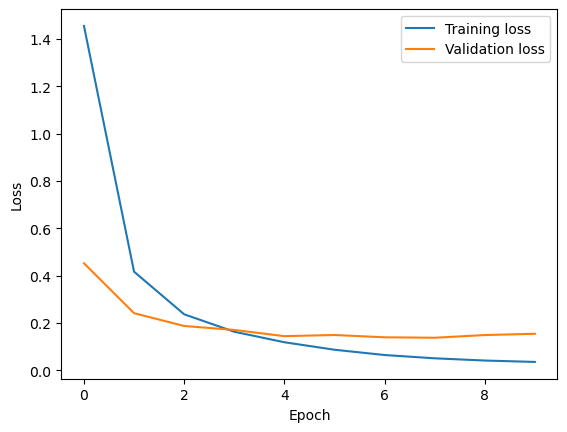

In [6]:
# Plotting validation and training loss
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Test: 100%|██████████| 961/961 [06:21<00:00,  2.52it/s]


Accuracy: 0.9657685799817779
Precision: 0.9660277807120793
Recall: 0.9657685799817779
F1: 0.9657606939729197
                 precision    recall  f1-score   support

           call       0.95      0.96      0.95       693
        dislike       0.97      0.98      0.98       702
           fist       0.98      0.98      0.98       688
           four       0.94      0.96      0.95       718
           like       0.96      0.94      0.95       682
           mute       0.99      0.98      0.98       713
     no_gesture       0.99      0.99      0.99      2782
             ok       0.95      0.97      0.96       692
            one       0.97      0.94      0.95       706
           palm       0.97      0.96      0.97       705
          peace       0.95      0.94      0.94       696
 peace_inverted       0.98      0.96      0.97       687
           rock       0.96      0.98      0.97       688
           stop       0.92      0.98      0.95       689
  stop_inverted       0.97      0.9

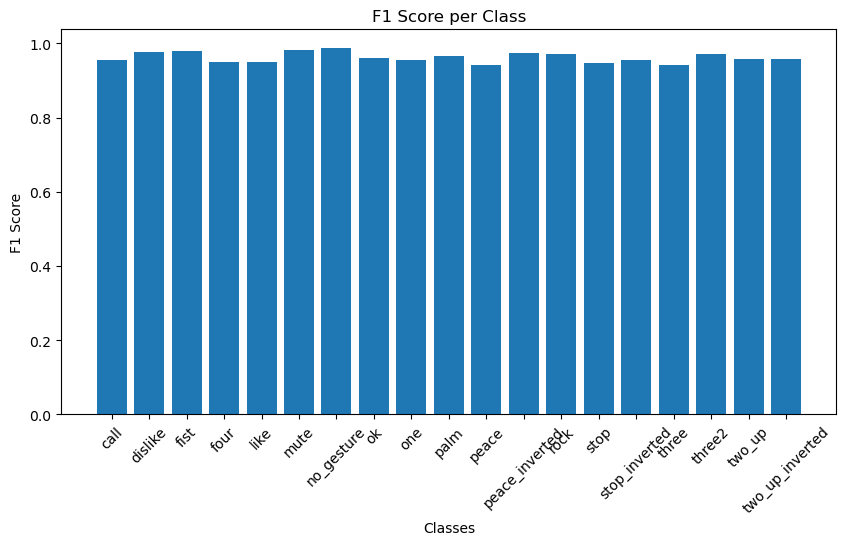

In [9]:
# Load the test data
test_dir = "D:\\Documents\\GitHub\\cv-gesture-recognition\\data\\classification\\test"
test_dataset = CustomDataset(test_dir, label_encoder, transform=image_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Build the model
saved_model = CombinedModel(hand_seg_model, mobilenetv3_model, input_size).to(device)
saved_model.to(device)
# Load the best model and load the state dict
best_model = torch.load('best_model_frozen.pth')
saved_model.load_state_dict(best_model['model_state_dict'])

# Variables to store the predictions and labels
all_preds = []
all_labels = []

# Put the Saved Model in evaluation mode
saved_model.eval()

# Disable gradient computation
with torch.no_grad():
    # Initialize tqdm progress bar for Test
    test_bar = tqdm(test_loader, desc='Test')

    # Iterate over the test data
    for batch in test_bar:
        # Get the inputs and labels
        input_ids, labels = batch
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = saved_model(input_ids)

        # Get the predicted labels
        #_, preds = torch.max(logits, dim=1)

        # Move preds and labels to CPU for further evaluation (if using GPU)
        preds = logits.cpu().numpy()
        labels = labels.cpu().numpy()

        # Extend the list of predictions and labels
        all_preds.extend(preds)
        all_labels.extend(labels)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Convert the predictions to binary
threshold = 0.5
all_preds_binary = []
for pred in all_preds:
    all_preds_binary.append(np.argmax(pred))

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds_binary)
precision = precision_score(all_labels, all_preds_binary, average='weighted')
recall = recall_score(all_labels, all_preds_binary, average='weighted')
f1 = f1_score(all_labels, all_preds_binary, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Generate metrics per class
from sklearn.metrics import classification_report
target_names = label_encoder.classes_
print(classification_report(all_labels, all_preds_binary, target_names=target_names))


# Show a bar plot of the F1 score per class
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
f1_scores = f1_score(all_labels, all_preds_binary, average=None)
plt.figure(figsize=(10, 5))
plt.bar(target_names, f1_scores)
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.title('F1 Score per Class')
plt.xticks(rotation=45)
plt.show()


### 2. **MobileNetV3 Large with Fine-tuned Hand Segmentation Model**

In this approach, the Hand Segmentation model will be fine-tuned with the MobileNetV3 Large model. The MobileNetV3 Large model will be trained with the hand gesture classifier. The Hand Segmentation model will be trained along with the MobileNetV3 Large model as part of the training process.

Everything is the same as the previous approach, except that the HandSegmentationModel is not frozen, so torch.nograd() is not used in the forward function of the CombinedModel for the HandSegmentationModel.

In [6]:
# Use GPU if available
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

# Load the hand segmentation model
hand_seg_model = HandSegModel.load_from_checkpoint('./checkpoint/checkpoint.ckpt', map_location=device)

# Do not freeze the hand segmentation model parameters
# for param in hand_seg_model.parameters():
#     param.requires_grad = False

# Generate the MobileNetV3 model
def generate_model(num_classes: int):
    model = models.mobilenet_v3_large(pretrained=True)
    # Modify the first layer to accept 4-channel input
    model.features[0][0] = nn.Conv2d(4, model.features[0][0].out_channels, kernel_size=3, stride=2, padding=1, bias=False)
    num_features = model.classifier[0].in_features
    model.classifier = nn.Sequential(
        nn.Linear(in_features=num_features, out_features=4096, bias=True),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(in_features=4096, out_features=4096, bias=True),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(in_features=4096, out_features=num_classes, bias=True)
    )
    return model


# Define a combined model
class CombinedModel(nn.Module):
    def __init__(self, hand_seg_model, mobilenet_model, input_size):
        super(CombinedModel, self).__init__()
        self.hand_seg_model = hand_seg_model
        self.mobilenet_model = mobilenet_model
        self.input_size = input_size  # Input size expected by MobileNetV3
    
    def forward(self, x):
        # Pass the input through the hand segmentation model
        logits = self.hand_seg_model(x)
        
        # Process the logits to obtain the segmentation mask
        preds = F.softmax(logits, 1).argmax(1).float().unsqueeze(1)  # [batch, 1, h, w]
        
        # Resize the predicted mask to match the input size expected by MobileNetV3
        preds = F.interpolate(preds, size=self.input_size, mode='bilinear', align_corners=False)
        
        # Normalize the mask to be in the same range as the input to MobileNetV3
        preds = preds / 255.0

        # Combine the RGB image and the segmentation mask
        combined_input = torch.cat([x, preds], dim=1)  # Combine along the channel dimension
        
        # Pass the combined input through MobileNetV3
        output = self.mobilenet_model(combined_input)
        return output

    
# Generate the mobilenetv3 model
mobilenetv3_model = generate_model(len(label_encoder.classes_)).to(device)

# Define the input size expected by MobileNetV3 (e.g., 300x300)
input_size = (WIDTH, HEIGHT)

# Instantiate the combined model
combined_model = CombinedModel(hand_seg_model, mobilenetv3_model, input_size).to(device)

Using cuda


c:\Users\berna\anaconda3\envs\cv-gesture\Lib\site-packages\pytorch_lightning\utilities\migration\migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.2.2 to v2.3.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint d:\Documents\GitHub\cv-gesture-recognition\handsegmentation\checkpoint\checkpoint.ckpt`
c:\Users\berna\anaconda3\envs\cv-gesture\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\berna\anaconda3\envs\cv-g

In [19]:
# Define the optimizer and loss function
optimizer = torch.optim.Adam(lr=1e-4, params=combined_model.parameters())
criterion = nn.CrossEntropyLoss()

# Define the learning rate scheduler
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=40)

# Define the class to save the best model based on the validation loss
save_best_model_instance = SaveModelWithBestValLoss(save_model_path='best_model_unfrozen.pth')

# Variables to store the training and validation losses
train_losses = []
val_losses = []
lrs = []

# Training Loop
for epoch in range(50):
    # Set to training mode
    combined_model.train()

    # Initialize tqdm progress bar for Training
    train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch}')
    train_loss = 0.0

    # Iterate over the training data
    for batch in train_bar:
        # Get the inputs and labels
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        logits = combined_model(inputs)
        
        # Compute loss
        loss = criterion(logits, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update the learning rate
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
        
        # Update the training loss
        train_loss += loss.item()
        train_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
    
    # Compute the average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation Loop
    val_loss = 0.0
    combined_model.eval()
    val_bar = tqdm(val_loader, desc=f'Validation Epoch {epoch}')
    
    # Iterate over the validation data without computing gradients
    with torch.no_grad():
        for batch in val_bar:
            # Get the inputs and labels
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = combined_model(inputs)
            
            # Compute loss
            loss = criterion(logits, labels)
            # Update the validation loss
            val_loss += loss.item()
            val_bar.set_postfix({'validation_loss': '{:.3f}'.format(loss.item()/len(batch))})
    
    # Compute the average validation loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    # Check if the validation loss has not improved for the last 3 epochs
    if len(val_losses) >= 4:
        diff_val_loss_1 = val_losses[-2] - val_losses[-1]
        diff_val_loss_2 = val_losses[-3] - val_losses[-1]
        diff_val_loss_3 = val_losses[-4] - val_losses[-1]
        # If the validation loss has not improved for the last 3 epochs, stop training
        if diff_val_loss_3 < 0 and diff_val_loss_2 < 0 and diff_val_loss_1 < 0:
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss} DID NOT IMPROVE')
            break
    
    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
    
    # Save the best model based on the validation loss
    save_best_model_instance.save(avg_val_loss, epoch, combined_model, optimizer, criterion)



Training Epoch 0:   2%|▏         | 34/1537 [00:20<14:54,  1.68it/s, training_loss=1.417]


KeyboardInterrupt: 

In [ ]:
# Plotting validation and training loss
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Test: 100%|██████████| 961/961 [06:21<00:00,  2.52it/s]


Accuracy: 0.9478068462840037
Precision: 0.9483578473110197
Recall: 0.9478068462840037
F1: 0.9477767523973559
                 precision    recall  f1-score   support

           call       0.97      0.93      0.95       693
        dislike       0.97      0.97      0.97       702
           fist       0.96      0.97      0.96       688
           four       0.95      0.89      0.92       718
           like       0.92      0.93      0.93       682
           mute       0.95      0.98      0.97       713
     no_gesture       0.98      0.98      0.98      2782
             ok       0.96      0.95      0.95       692
            one       0.95      0.90      0.92       706
           palm       0.94      0.97      0.95       705
          peace       0.89      0.90      0.90       696
 peace_inverted       0.96      0.93      0.95       687
           rock       0.95      0.94      0.94       688
           stop       0.90      0.96      0.93       689
  stop_inverted       0.98      0.9

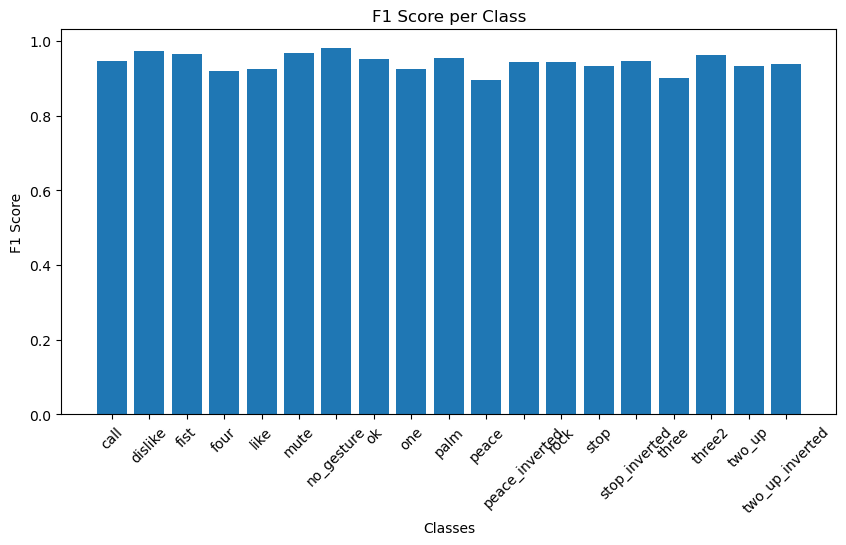

In [7]:
# Load the test data
test_dir = "D:\\Documents\\GitHub\\cv-gesture-recognition\\data\\classification\\test"
test_dataset = CustomDataset(test_dir, label_encoder, transform=image_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Build the model
saved_model = CombinedModel(hand_seg_model, mobilenetv3_model, input_size).to(device)
saved_model.to(device)

# Load the best model and load the state dict
best_model = torch.load('best_model_unfrozen.pth')
saved_model.load_state_dict(best_model['model_state_dict'])

# Variables to store the predictions and labels
all_preds = []
all_labels = []

# Put the Saved Model in evaluation mode
saved_model.eval()

# Disable gradient computation
with torch.no_grad():
    # Initialize tqdm progress bar for Test
    test_bar = tqdm(test_loader, desc='Test')

    # Iterate over the test data
    for batch in test_bar:
        # Get the inputs and labels
        input_ids, labels = batch
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = saved_model(input_ids)

        # Get the predicted labels
        #_, preds = torch.max(logits, dim=1)

        # Move preds and labels to CPU for further evaluation (if using GPU)
        preds = logits.cpu().numpy()
        labels = labels.cpu().numpy()

        # Extend the list of predictions and labels
        all_preds.extend(preds)
        all_labels.extend(labels)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Convert the predictions to binary
threshold = 0.5
all_preds_binary = []
for pred in all_preds:
    all_preds_binary.append(np.argmax(pred))

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds_binary)
precision = precision_score(all_labels, all_preds_binary, average='weighted')
recall = recall_score(all_labels, all_preds_binary, average='weighted')
f1 = f1_score(all_labels, all_preds_binary, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Generate metrics per class
from sklearn.metrics import classification_report
target_names = label_encoder.classes_
print(classification_report(all_labels, all_preds_binary, target_names=target_names))


# Show a bar plot of the F1 score per class
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
f1_scores = f1_score(all_labels, all_preds_binary, average=None)
plt.figure(figsize=(10, 5))
plt.bar(target_names, f1_scores)
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.title('F1 Score per Class')
plt.xticks(rotation=45)
plt.show()
